In [1]:
''' Final project for CS 230 - Detection depression with text, audio, and possibly video data'''

' Final project for CS 230 - Detection depression with text, audio, and possibly video data'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.figure_factory as ff
from scipy import stats

import gensim
import json


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import itertools

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')

C:\Users\diogo\Anaconda3\envs\tf\lib\site-packages\gensim\utils.py:1197: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial

Using TensorFlow backend.


In [2]:
#nltk.download('wordnet')
#nltk.download('stopwords')
wordnet_lemmatizer = WordNetLemmatizer()

In [14]:
WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

In [3]:
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

In [4]:
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all.csv', sep=',')
    print("File was created")
    return all_participants

In [5]:
data_path = "data/raw/transcripts/"
all_participants = pd.read_csv(data_path + 'all.csv', sep=',')

In [6]:
all_participants.columns =  ['index','personId', 'question', 'answer']
all_participants = all_participants.astype({"index": int, "personId": float, "question": str, "answer": str })

In [7]:
all_participants.head()

,index,personId,question,answer
0,0,300.0,hi i'm ellie thanks for coming in today,nan
1,1,300.0,i was created to talk to people in a safe and ...,nan
2,2,300.0,think of me as a friend i don't judge i can't ...,nan
3,3,300.0,i'm here to learn about people and would love ...,nan
4,4,300.0,i'll ask a few questions to get us started and...,nan


In [8]:
# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [9]:
all_participants_mix = all_participants.copy()
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)

In [10]:
all_participants_mix_stopwords = all_participants.copy()
all_participants_mix_stopwords['answer'] = all_participants_mix_stopwords.apply(lambda row: text_to_wordlist(row.answer, remove_stopwords=False).split(), axis=1)

In [11]:
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words))
vocab_size = len(words)

In [12]:
words_stop = [w for w in all_participants_mix_stopwords['answer'].tolist()]
words_stop = set(itertools.chain(*words_stop))
vocab_size_stop = len(words_stop)

In [43]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer'])
tokenizer.fit_on_sequences(all_participants_mix['answer'])

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix.head()

,index,personId,question,answer,t_answer
0,0,300.0,hi i'm ellie thanks for coming in today,[],[]
1,1,300.0,i was created to talk to people in a safe and ...,[],[]
2,2,300.0,think of me as a friend i don't judge i can't ...,[],[]
3,3,300.0,i'm here to learn about people and would love ...,[],[]
4,4,300.0,i'll ask a few questions to get us started and...,[],[]


In [16]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size_stop)
tokenizer.fit_on_texts(all_participants_mix_stopwords['answer'])
tokenizer.fit_on_sequences(all_participants_mix_stopwords['answer'])

all_participants_mix_stopwords['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix_stopwords['answer'])
all_participants_mix_stopwords.head()

,index,personId,question,answer,t_answer
0,0,300.0,hi i'm ellie thanks for coming in today,[],[]
1,1,300.0,i was created to talk to people in a safe and ...,[],[]
2,2,300.0,think of me as a friend i don't judge i can't ...,[],[]
3,3,300.0,i'm here to learn about people and would love ...,[],[]
4,4,300.0,i'll ask a few questions to get us started and...,[],[]


In [44]:
word_index = tokenizer.word_index
word_size = len(word_index)
print(word_index["happy"])

69


In [86]:
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp_stop = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix_stopwords.groupby('personId').agg('sum', axis=1)

for p in answers.iterrows():      
    words = p[1]["answer"]
    size = len(words)
    word_tokens = p[1]["t_answer"]
 
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp_stop.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

In [45]:
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix.groupby('personId').agg('sum', axis=1)

for p in answers.iterrows():      
    words = p[1]["answer"]
    size = len(words)
    word_tokens = p[1]["t_answer"]
 
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

In [58]:
phrases_lp.head()
phrases_lp.to_csv(data_path + 'phrases_lp.csv', sep='\t')
print("File was created")

File was created


In [89]:
phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, my, parent, are, ...","[42, 1727, 2089, 5, 12, 205, 37, 69, 113, 5]"
1,300.0,"[atlanta, georgia, um, my, parent, are, from, ...","[1727, 2089, 5, 12, 205, 37, 69, 113, 5, 1]"
2,300.0,"[georgia, um, my, parent, are, from, here, um,...","[2089, 5, 12, 205, 37, 69, 113, 5, 1, 119]"
3,300.0,"[um, my, parent, are, from, here, um, i, love,...","[5, 12, 205, 37, 69, 113, 5, 1, 119, 6]"
4,300.0,"[my, parent, are, from, here, um, i, love, it, i]","[12, 205, 37, 69, 113, 5, 1, 119, 6, 1]"


In [90]:
phrases_lp_stop.to_csv(data_path + 'phrases_lp_stop.csv', sep='\t')
print("File was created")

File was created


In [18]:
phrases_lp = pd.read_csv(data_path + 'phrases_lp.csv', sep='\t', converters={"t_answer": literal_eval}) 
phrases_lp.head()

,Unnamed: 0,personId,answer,t_answer
0,0,300.0,"['good', 'atlanta', 'georgia', 'um', 'parent',...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,1,300.0,"['atlanta', 'georgia', 'um', 'parent', 'um', '...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,2,300.0,"['georgia', 'um', 'parent', 'um', 'love', 'lik...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,3,300.0,"['um', 'parent', 'um', 'love', 'like', 'weathe...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,4,300.0,"['parent', 'um', 'love', 'like', 'weather', 'l...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [19]:
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [20]:
train = load_avec_dataset_file('data/train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('data/dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('data/full_test_split.csv', 'PHQ8_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


In [21]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [87]:
ds_total.to_csv(data_path + 'ds_total.csv', sep='\t')
print("File was created")

File was created


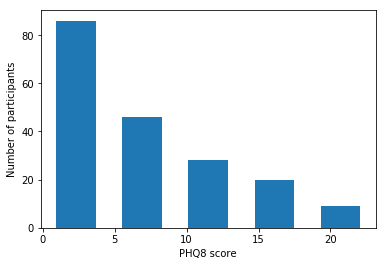

<Figure size 432x288 with 0 Axes>

In [104]:
bins=[-1,0,5,10,15,25]
plt.figure()
plt.hist(ds_total["PHQ8_Score"], rwidth=0.6, bins=5)
plt.xlabel('PHQ8 score')
plt.ylabel('Number of participants')
plt.show()
plt.savefig('figures/bins.png')

In [26]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [27]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


In [28]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])

In [29]:
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')

In [30]:
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])


In [31]:
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

In [85]:
def test_model(text, model):
    print(text)
    word_list = text_to_wordlist(text)
    sequences = tokenizer.texts_to_sequences([word_list])
    sequences_input = list(itertools.chain(*sequences))
    sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
    input_a = np.asarray(sequences_input)
    pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
    predicted_class = np.argmax(pred)
    print(labels[predicted_class])

In [33]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [34]:
embeddings_index = dict()
f = open('word2vec/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [35]:
def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index)
    embedding_matrix = np.zeros((vocab_size+1, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [36]:
embedding_matrix_lp = fill_embedding_matrix(tokenizer)

In [37]:
train_a = np.stack(train_lp['t_answer'], axis=0)
dev_a = np.stack(dev_lp['t_answer'], axis=0)
train_y = np.stack(train_lp['cat_level'], axis=0)
dev_y = np.stack(dev_lp['cat_level'], axis=0)

In [38]:
train_a_b = np.stack(train_lp_b['t_answer'], axis=0)
dev_a_b = np.stack(dev_lp_b['t_answer'], axis=0)
train_y_b = np.stack(train_lp_b['cat_level'], axis=0)
dev_y_b = np.stack(dev_lp_b['cat_level'], axis=0)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [41]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(5,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           25856     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 256)           65792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
__________

In [42]:
model_glove_lstm_hist = model.fit(train_a, train_y, validation_data=(dev_a, dev_y), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 99969 samples, validate on 19993 samples
Epoch 1/30
99969/99969 [==============================] - 29s 288us/step - loss: 1.4552 - acc: 0.3693 - val_loss: 1.3352 - val_acc: 0.4354
Epoch 2/30
99969/99969 [==============================] - 29s 290us/step - loss: 1.2720 - acc: 0.4715 - val_loss: 1.1082 - val_acc: 0.5519
Epoch 3/30
99969/99969 [==============================] - 29s 291us/step - loss: 1.1071 - acc: 0.5497 - val_loss: 0.9320 - val_acc: 0.6294
Epoch 4/30
99969/99969 [==============================] - 31s 308us/step - loss: 0.9967 - acc: 0.5998 - val_loss: 0.8114 - val_acc: 0.6876
Epoch 5/30
99969/99969 [==============================] - 31s 313us/step - loss: 0.9135 - acc: 0.6416 - val_loss: 0.6972 - val_acc: 0.7393
Epoch 6/30
99969/99969 [==============================] - 31s 306us/step - loss: 0.8512 - acc: 0.6674 - val_loss: 0.6390 - val_acc: 0.7669
Epoch 7/30
99969/99969 [==============================] - 30s 297us/step - loss: 0.7997 - acc: 0.6886 - val_loss: 0.

In [46]:
model_glove_lstm_hist_b = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 65256 samples, validate on 13051 samples
Epoch 1/30
65256/65256 [==============================] - 21s 316us/step - loss: 0.3983 - acc: 0.8562 - val_loss: 0.0901 - val_acc: 0.9777
Epoch 2/30
65256/65256 [==============================] - 20s 306us/step - loss: 0.3427 - acc: 0.8753 - val_loss: 0.0699 - val_acc: 0.9816
Epoch 3/30
65256/65256 [==============================] - 21s 326us/step - loss: 0.3213 - acc: 0.8825 - val_loss: 0.0714 - val_acc: 0.9795
Epoch 4/30
65256/65256 [==============================] - 21s 324us/step - loss: 0.3030 - acc: 0.8903 - val_loss: 0.0662 - val_acc: 0.9819
Epoch 5/30
65256/65256 [==============================] - 22s 333us/step - loss: 0.2823 - acc: 0.8994 - val_loss: 0.0629 - val_acc: 0.9820
Epoch 6/30
65256/65256 [==============================] - 22s 330us/step - loss: 0.2791 - acc: 0.8999 - val_loss: 0.0642 - val_acc: 0.9822
Epoch 7/30
65256/65256 [==============================] - 22s 334us/step - loss: 0.2642 - acc: 0.9056 - val_loss: 0.

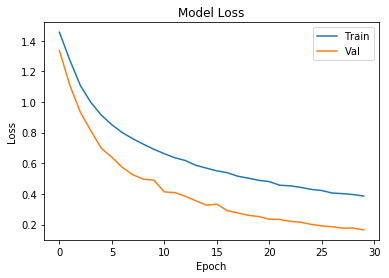

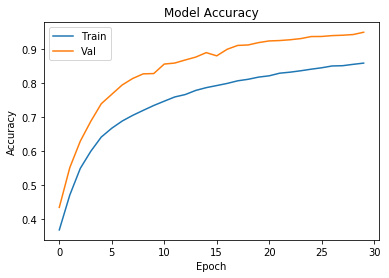

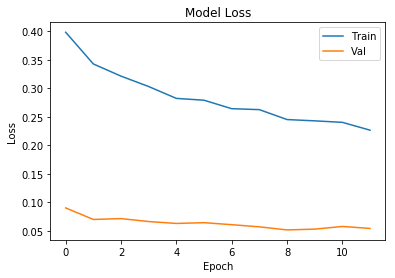

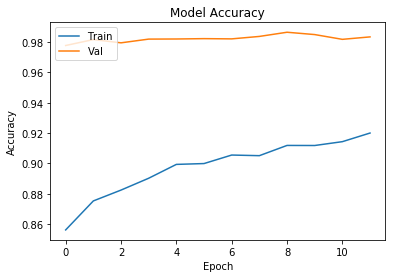

In [48]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)
plot_loss(model_glove_lstm_hist_b)
plot_acc(model_glove_lstm_hist_b)

In [79]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a_b, test_y_b)

In [80]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3533,19,21,8,12
mild,8,2881,23,7,15
moderate,8,9,3084,5,18
moderately severe,12,11,34,2770,16
severe,7,6,5,5,2398


In [74]:
score = model.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05473436229941535
Test accuracy: 0.9833053972510895


In [44]:
model.save('models/model_glove_lstm_b.h5')

with open('models/model_glove_lstm_b_hist.json', 'w') as f:
    json.dump(model_glove_lstm_hist.history, f)

In [102]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model)
sen = "I am a graduate student"
test_model(sen, model)
sen = "I am getting married"
test_model(sen, model)
sen = "This party is great, I know lots of people"
test_model(sen, model)
sen = "I miss my parents, brothers and sisters"
test_model(sen, model)
sen = "I detest my horrible job"
test_model(sen, model)
sen = "suicide"
test_model(sen, model)

All is going right with the party, I'm happy to know new people
none
I want an ice cream and have some fries for lunch
mild
I'm afraid of losing my work, I don't have any money
severe
I'm worried about my future, I'm afraid of it
severe
I am a graduate student
none
I am getting married
severe
This party is great, I know lots of people
none
I miss my parents, brothers and sisters
mild
I detest my horrible job
moderate
suicide
severe


In [60]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


lstm1 = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(answer_emb1)
lstm2 = LSTM(embedding_size_glove, dropout=0.2, recurrent_dropout=0.2)(lstm1)

X = Dropout(0.2)(lstm2)
bt = BatchNormalization()(X)
dense1 = Dense(units=256, activation="relu")(bt)

out = Dense(5,  activation='softmax')(dense1)

model_2lstm = Model(inputs=[answer_inp], outputs=[out])
model_2lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_2lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25856     
__________

In [70]:
model_glove_2lstm_b_hist = model_2lstm.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 65256 samples, validate on 13051 samples
Epoch 1/30
65256/65256 [==============================] - 18s 283us/step - loss: 0.7295 - acc: 0.7238 - val_loss: 0.4549 - val_acc: 0.8511
Epoch 2/30
65256/65256 [==============================] - 22s 340us/step - loss: 0.7224 - acc: 0.7290 - val_loss: 0.4402 - val_acc: 0.8556
Epoch 3/30
65256/65256 [==============================] - 22s 343us/step - loss: 0.7169 - acc: 0.7293 - val_loss: 0.4431 - val_acc: 0.8557
Epoch 4/30
65256/65256 [==============================] - 23s 351us/step - loss: 0.7047 - acc: 0.7353 - val_loss: 0.4246 - val_acc: 0.8611
Epoch 5/30
65256/65256 [==============================] - 23s 359us/step - loss: 0.6928 - acc: 0.7403 - val_loss: 0.4180 - val_acc: 0.8601
Epoch 6/30
65256/65256 [==============================] - 24s 367us/step - loss: 0.6982 - acc: 0.7378 - val_loss: 0.4089 - val_acc: 0.8646
Epoch 7/30
65256/65256 [==============================] - 24s 361us/step - loss: 0.6866 - acc: 0.7425 - val_loss: 0.

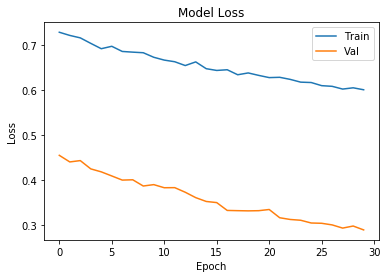

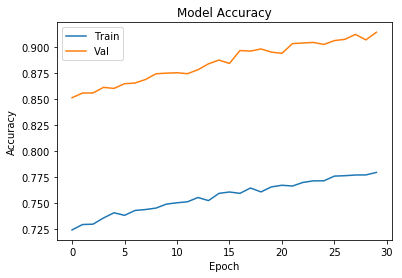

In [71]:
plot_loss(model_glove_2lstm_b_hist)
plot_acc(model_glove_2lstm_b_hist)

In [76]:
score = model_2lstm.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2921677132450891
Test accuracy: 0.9124371438149514


In [81]:
df_confusion = confusion_matrix(model_2lstm, test_a_b, test_y_b)

In [82]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3319,72,106,50,46
mild,71,2701,62,59,41
moderate,74,37,2903,45,65
moderately severe,123,45,110,2510,55
severe,65,58,74,48,2176


In [56]:
model_2lstm.save('models/model_glove_2lstm_b.h5')

with open('models/model_glove_2lstm_b_hist.json', 'w') as f:
    json.dump(model_glove_2lstm_b_hist.history, f)

In [103]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_2lstm)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_2lstm)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model_2lstm)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model_2lstm)
sen = "My father loves me"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
mild
I want an ice cream and have some fries for lunch
mild
I'm afraid of losing my work, I don't have any money
moderate
I'm worried about my future, I'm afraid of it
mild
My father loves me
moderate
